In [ ]:
!git clone https://github.com/DiploDatos/AprendizajePorRefuerzos.git


Cloning into 'AprendizajePorRefuerzos'...
remote: Enumerating objects: 1088, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 1088 (delta 173), reused 167 (delta 150), pack-reused 839 (from 2)
Receiving objects: 100% (1088/1088), 83.66 MiB | 22.35 MiB/s, done.
Resolving deltas: 100% (544/544), done.
Updating files: 100% (75/75), done.
Filtering content: 100% (2/2), 8.60 MiB | 6.40 MiB/s, done.


In [ ]:
%cd AprendizajePorRefuerzos/tp_decision_transformer

/content/AprendizajePorRefuerzos/tp_decision_transformer


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Parte 1

In [ ]:
import pandas as pd
import numpy as np
import json

# ============================================
# 🎯 CONFIGURACIÓN: ELEGIR DATASET
# ============================================
# Descomentar el dataset que quieras usar:

#DATASET = 'netflix'    # Opción 1: Películas (752 items)
DATASET = 'goodreads'  # Opción 2: Libros (472 items)

# Configurar paths según el dataset elegido
if DATASET == 'netflix':
    NUM_ITEMS = 752
    train_path = 'data/train/netflix8_train.df'
    test_path = 'data/test_users/netflix8_test.json'
    centroids_path = 'data/groups/mu_netflix8.csv'
    item_name = 'películas'
elif DATASET == 'goodreads':
    NUM_ITEMS = 472
    train_path = 'data/train/goodreads8_train.df'
    test_path = 'data/test_users/goodreads8_test.json'
    centroids_path = 'data/groups/mu_goodreads8.csv'
    item_name = 'libros'

print(f"📊 Dataset seleccionado: {DATASET.upper()}")
print(f"📦 Número de items: {NUM_ITEMS} {item_name}")
print("="*60)

# === CARGAR TRAINING DATA ===
df_train = pd.read_pickle(train_path)

print(f"\nNúmero de usuarios: {len(df_train)}")
print(f"Columnas: {df_train.columns.tolist()}")

# Ver un usuario ejemplo
user_0 = df_train.iloc[0]
print(f"\nUsuario 0:")
print(f"  Grupo: {user_0['user_group']}")
print(f"  # de ratings: {len(user_0['items'])}")
print(f"  Primeros 5 {item_name} vistos: {user_0['items'][:5]}")
print(f"  Primeros 5 ratings: {user_0['ratings'][:5]}")

# === CARGAR TEST DATA ===
with open(test_path, 'r') as f:
    test_users = json.load(f)

print(f"\nNúmero de usuarios de test: {len(test_users)}")
print(f"\nUsuario de test 0:")
print(f"  Grupo: {test_users[0]['group']}")
print(f"  Rating para item 0: {test_users[0]['ratings'][0]}")
print(f"  Rating para item 100: {test_users[0]['ratings'][100]}")

# === CARGAR CENTROIDES (OPCIONAL) ===
mu = pd.read_csv(centroids_path, header=None)
print(f"\nCentroides shape: {mu.shape}")  # (8, NUM_ITEMS)
print(f"Rating promedio del grupo 0 para item 0: {mu.iloc[0, 0]:.2f}")

📊 Dataset seleccionado: GOODREADS
📦 Número de items: 472 libros

Número de usuarios: 16000
Columnas: ['user_id', 'user_group', 'items', 'ratings']

Usuario 0:
  Grupo: 0
  # de ratings: 173
  Primeros 5 libros vistos: [417 302 125 279 235]
  Primeros 5 ratings: [5. 4. 5. 4. 4.]

Número de usuarios de test: 1600

Usuario de test 0:
  Grupo: 0
  Rating para item 0: 5
  Rating para item 100: 2.38

Centroides shape: (8, 472)
Rating promedio del grupo 0 para item 0: 4.37


## Análisis exploratorio

In [ ]:
df_train.head()

,user_id,user_group,items,ratings
0,0,0,"[417, 302, 125, 279, 235, 342, 73, 443, 137, 2...","[5.0, 4.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, ..."
1,1,0,"[243, 0, 280, 148, 244, 366, 288, 392, 228, 22...","[3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, ..."
2,2,0,"[154, 183, 86, 255, 372, 321, 366, 63, 254, 20...","[4.0, 4.0, 5.0, 5.0, 4.0, 3.0, 5.0, 3.0, 2.0, ..."
3,3,0,"[74, 173, 182, 214, 303, 446, 342, 254, 70, 13...","[3.0, 5.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 3.0, ..."
4,4,0,"[53, 103, 0, 413, 302, 29, 228, 446, 196, 419,...","[3.0, 3.0, 3.0, 4.0, 3.0, 5.0, 5.0, 5.0, 4.0, ..."


In [ ]:
print("\n" + "="*60)
print(" ESTADÍSTICAS BÁSICAS")
print("="*60)

# Número de usuarios
num_users = len(df_train)

# Cantidad de interacciones por usuario
seq_lengths = df_train["items"].apply(len)

# Todos los ratings juntos
all_ratings = np.concatenate(df_train["ratings"].values)

print(f" Número de usuarios: {num_users}")
print(f" Número total de interacciones: {seq_lengths.sum()}")
print(f" Longitud promedio de secuencia: {seq_lengths.mean():.2f}")
print(f"   Longitud mínima: {seq_lengths.min()}")
print(f"   Longitud máxima: {seq_lengths.max()}")

print(f" Rating mínimo: {all_ratings.min()}")
print(f" Rating máximo: {all_ratings.max()}")
print(f" Rating promedio: {all_ratings.mean():.2f}")

# Conteo de ratings
rating_counts = pd.Series(all_ratings).value_counts().sort_index()
print("\n Distribución de ratings:")
print(rating_counts)


 ESTADÍSTICAS BÁSICAS
 Número de usuarios: 16000
 Número total de interacciones: 1796862
 Longitud promedio de secuencia: 112.30
   Longitud mínima: 25
   Longitud máxima: 200
 Rating mínimo: 1.0
 Rating máximo: 5.0
 Rating promedio: 3.55

 Distribución de ratings:
1.0    133964
2.0    219623
3.0    419364
4.0    572481
5.0    451430
Name: count, dtype: int64


El siguiente plot muestra la distribución de las longitudes de secuencias de libros. La mínima cantidad de libros leídos por los usuarios es 25, la máxima cantidad es 200 y en promedio los usuarios han leído 112.303875 libros.

Longitud mínima de secuencia: 25
Longitud máxima de secuencia: 200
Longitud promedio de secuencia: 112.303875


<Axes: xlabel='len_sequence', ylabel='Count'>

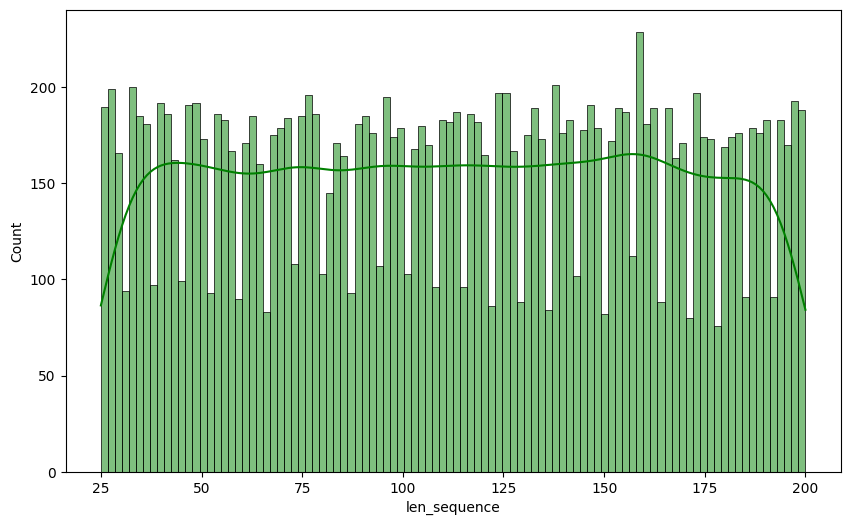

In [ ]:

df_train['len_sequence'] = df_train['items'].apply(len)
print(f"Longitud mínima de secuencia: {df_train['len_sequence'].min()}")
print(f"Longitud máxima de secuencia: {df_train['len_sequence'].max()}")
print(f"Longitud promedio de secuencia: {df_train['len_sequence'].mean()}")

fig = plt.figure(figsize=(10, 6))
sns.histplot(df_train['len_sequence'], bins=100, kde=True, color='green')

La distribución general de los ratings es la que se presenta en el siguiente gráfico. Se observa que el rating 4 aparece con mayor frecuencia.

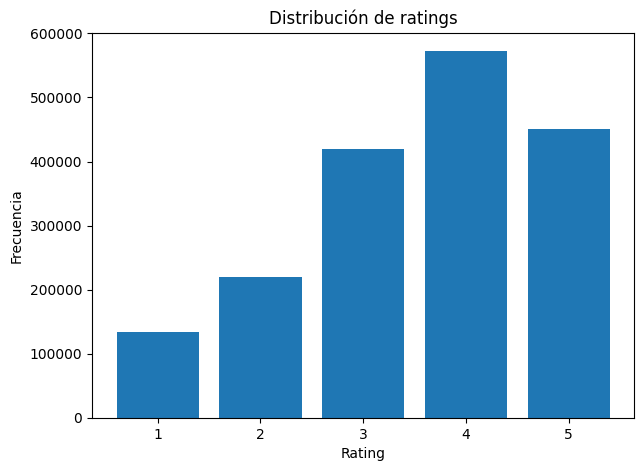

In [ ]:
# Todas las ratings juntas
all_ratings = np.concatenate(df_train["ratings"].values)
rating_counts = pd.Series(all_ratings).value_counts().sort_index()

plt.figure(figsize=(7,5))
plt.bar(rating_counts.index, rating_counts.values)
plt.title("Distribución de ratings")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.xticks(rating_counts.index)
plt.show()


Cada grupo posee 2000 usuarios:

In [ ]:
print(df_train.user_group.unique())
print(f"Cantidad de usuarios por grupo:\n{df_train['user_group'].value_counts().sort_index()}")


[0 1 2 3 4 5 6 7]
Cantidad de usuarios por grupo:
user_group
0    2000
1    2000
2    2000
3    2000
4    2000
5    2000
6    2000
7    2000
Name: count, dtype: int64


Y la distribución de ratings en cada grupo de usuarios, la podemos ver en los siguientes dos gráficos (boxplot e histogramas). Para ello necesitamos el dataframe expandido `df_expanded2` que nos permite permite ver para cada usuario, un libro y su respectivo puntaje en una única fila.

Se observa que el grupo 2 tiende a tener mayor cantidad de libros con alta puntuación, mientras que el grupo 6 posee más libros con baja puntuación

In [ ]:
df_expanded2 = (
    df_train
    .explode(['items','ratings'])
    .rename(columns={'items': 'item_id', 'ratings': 'rating'})
    .reset_index(drop=True)
)

df_expanded2.head()




,user_id,user_group,item_id,rating,len_sequence
0,0,0,417,5.0,173
1,0,0,302,4.0,173
2,0,0,125,5.0,173
3,0,0,279,4.0,173
4,0,0,235,4.0,173


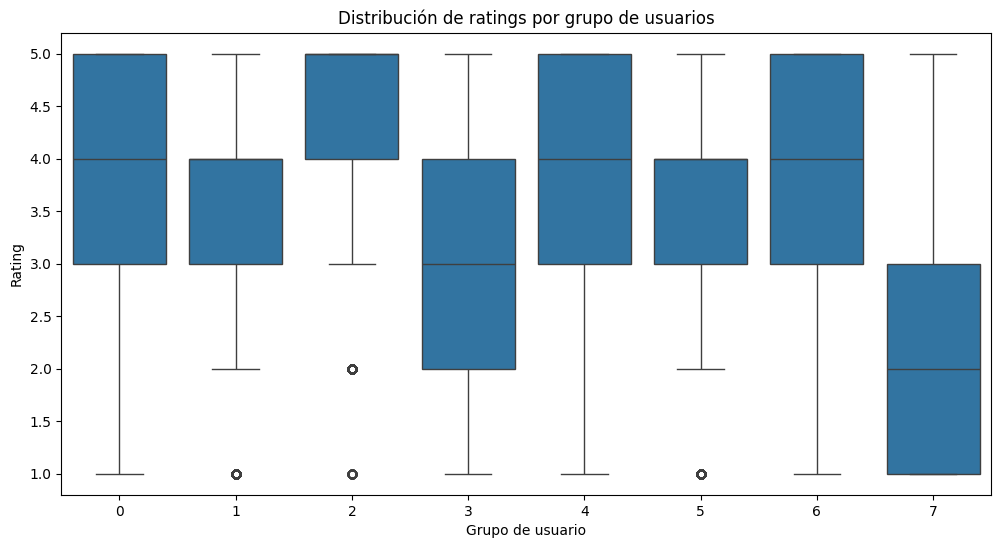

In [ ]:


plt.figure(figsize=(12, 6))
sns.boxplot(data=df_expanded2, x='user_group', y='rating')
plt.title('Distribución de ratings por grupo de usuarios')
plt.xlabel('Grupo de usuario')
plt.ylabel('Rating')
plt.show()

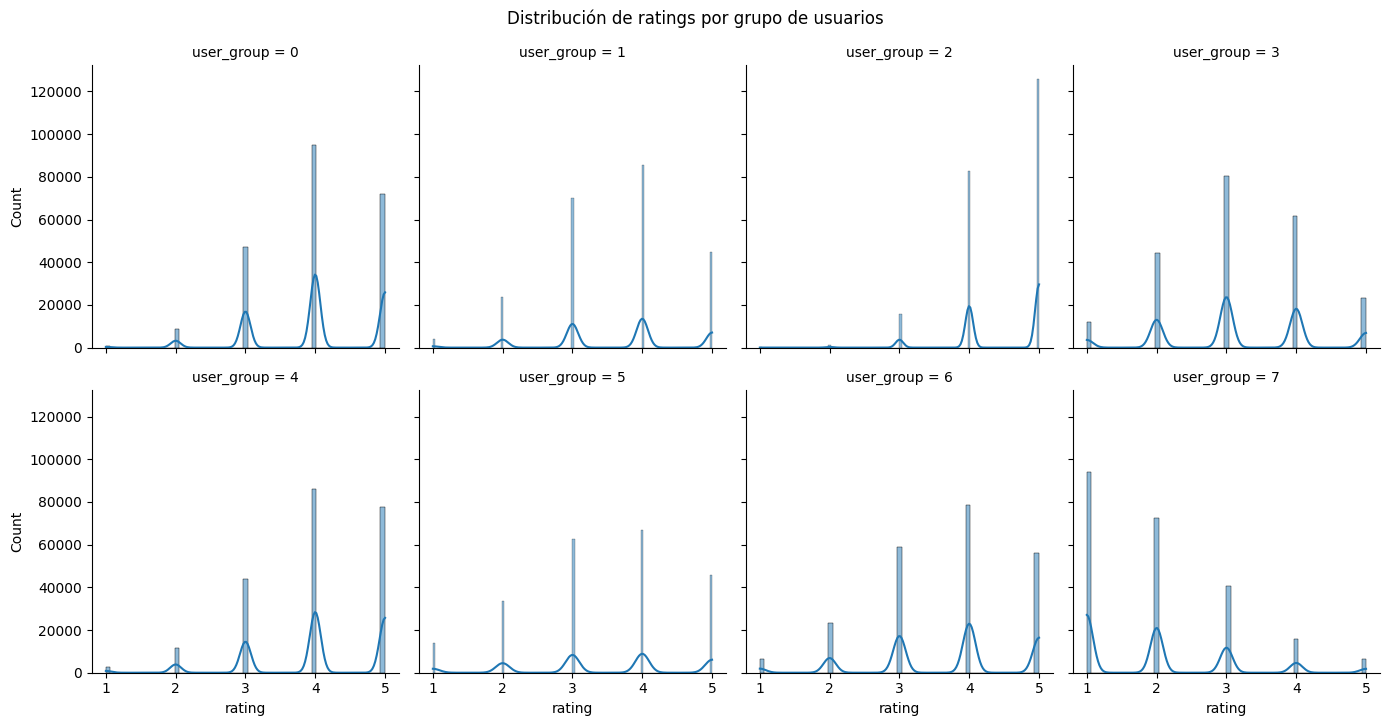

In [ ]:
g = sns.FacetGrid(df_expanded2, col="user_group", col_wrap=4, height=3.5, sharex=True, sharey=True)
g.map(sns.histplot, "rating", kde=True)
g.fig.suptitle('Distribución de ratings por grupo de usuarios', y=1.03)
plt.show()


En el siguiente gráfico se aprecia de manera más clara los comportamientos extremadamente diferentes de los grupos 2 y 6 mientras que el resto de los grupos se comportan aproximadamente parecido.

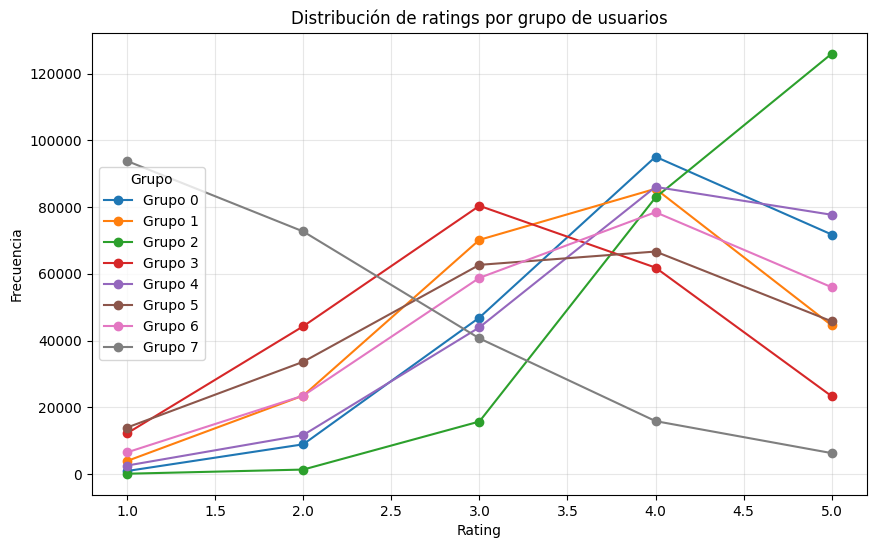

In [ ]:

# Diccionario para guardar ratings por grupo
ratings_by_group = {}

# Para cada grupo, juntar todos los ratings
for group in sorted(df_train["user_group"].unique()):
    group_ratings = np.concatenate(df_train[df_train["user_group"] == group]["ratings"].values)
    ratings_by_group[group] = pd.Series(group_ratings)

# Graficar
plt.figure(figsize=(10,6))

for group, series in ratings_by_group.items():
    freq = series.value_counts().sort_index()   # ordenado por rating
    plt.plot(freq.index, freq.values, marker="o", label=f"Grupo {group}")

plt.title("Distribución de ratings por grupo de usuarios")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.legend(title="Grupo")
plt.grid(alpha=0.3)
plt.show()

En los siguientes gráficos podemos ver la frecuencia de los 20 libros más populares y los 20 libros menos populares.

In [ ]:
item_counts = df_expanded2['item_id'].value_counts()

top20 = item_counts.head(20)
bottom20 = item_counts.tail(20)


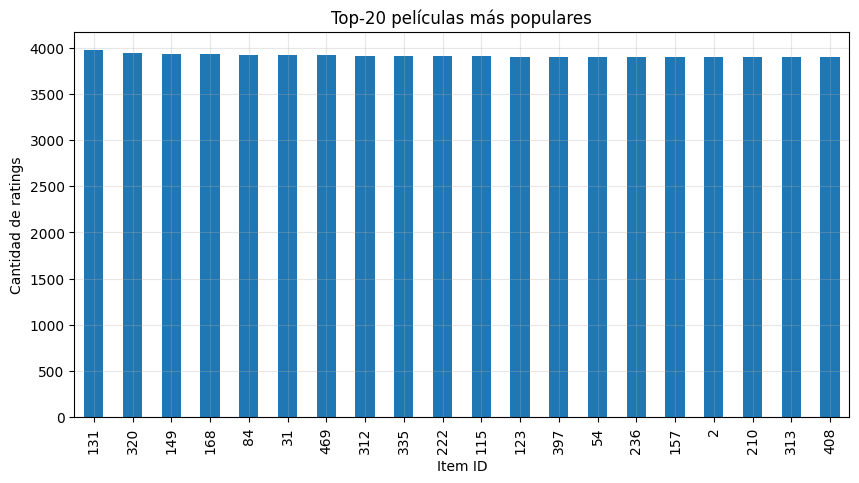

In [ ]:
plt.figure(figsize=(10,5))
top20.plot(kind='bar')
plt.title("Top-20 películas más populares")
plt.xlabel("Item ID")
plt.ylabel("Cantidad de ratings")
plt.grid(True, alpha=0.3)
plt.show()


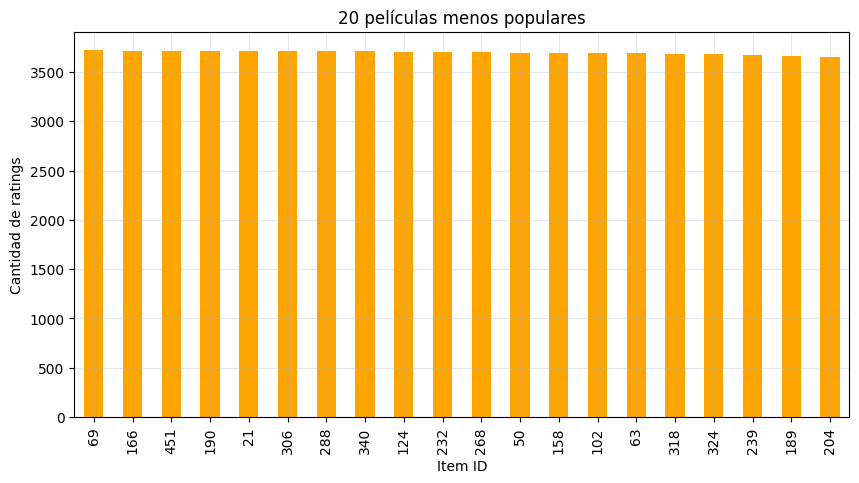

In [ ]:
plt.figure(figsize=(10,5))
bottom20.plot(kind='bar', color='orange')
plt.title("20 películas menos populares")
plt.xlabel("Item ID")
plt.ylabel("Cantidad de ratings")
plt.grid(True, alpha=0.3)
plt.show()


Por último, se analizó si había relación lineal entre los ratings y la frecuencia de aparición. Para eso generamos el dataframe `df_expanded` y graficamos un scatterplot. Se observa que no hay ninguna relación entre los ratings y las frecuencia de aparición de cada libro.

In [ ]:
# Expandir listas de items y ratings para tener una fila por item
df_expanded = (
    df_train
    .explode(['items', 'ratings'])
    .rename(columns={'items': 'item_id', 'ratings': 'rating'})
)

# Calcular rating promedio por ítem
item_mean_df = (
    df_expanded
    .groupby('item_id')['rating']
    .mean()
    .reset_index()
    .sort_values('rating', ascending=False)
)

# Calcular frecuencia de aparición de cada ítem
item_freq = df_expanded['item_id'].value_counts().reset_index()
item_freq.columns = ['item_id', 'frequency']

# Unir rating promedio y frecuencia
item_mean_df = item_mean_df.merge(item_freq, on='item_id')
item_mean_df = item_mean_df.sort_values('frequency', ascending=True)

df_expanded.head()

,user_id,user_group,item_id,rating,len_sequence
0,0,0,417,5.0,173
0,0,0,302,4.0,173
0,0,0,125,5.0,173
0,0,0,279,4.0,173
0,0,0,235,4.0,173


Correlación entre frecuencia y calificación promedio: -0.0289


<Axes: xlabel='frequency', ylabel='rating'>

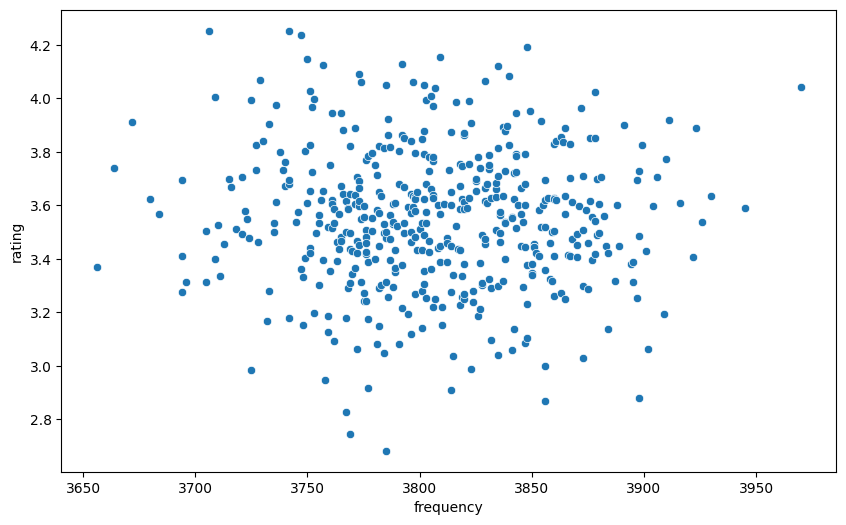

In [ ]:
correlation = item_mean_df['frequency'].corr(item_mean_df['rating'])
print(f'Correlación entre frecuencia y calificación promedio: {correlation:.4f}')

df_expanded.head()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=item_mean_df, x='frequency', y='rating')


## Preprocesamiento

In [ ]:
import numpy as np

def create_dt_dataset(df_train):
    """
    Convierte df_train al formato requerido por un Decision Transformer.

    Recibe:
        df_train: DataFrame con columnas [user_id, user_group, items, ratings]

    Devuelve:
        trajectories: lista de diccionarios, uno por usuario.
    """
    trajectories = []

    for _, row in df_train.iterrows():
        # Extraer secuencias crudas del dataset
        items = row["items"]        # numpy array
        ratings = row["ratings"]    # numpy array
        group = row["user_group"]   # int 0–7

        # ================================
        # 1) Calcular returns-to-go (RTG)
        # ================================
        T = len(ratings)
        returns = np.zeros(T)

        # Último paso
        returns[-1] = ratings[-1]

        # Hacia atrás: RTG[t] = r[t] + RTG[t+1]
        for t in range(T - 2, -1, -1):
            returns[t] = ratings[t] + returns[t + 1]

        # ================================
        # 2) Crear diccionario trayectoria
        # ================================
        trajectory = {
            "items": items,
            "ratings": ratings,
            "returns_to_go": returns,
            "timesteps": np.arange(T),
            "user_group": group,
        }

        trajectories.append(trajectory)

    return trajectories


In [ ]:
def validate_preprocessing(trajectories):
    """
    Valida las propiedades básicas del dataset DT.
    """

    for i, traj in enumerate(trajectories):

        items = traj["items"]
        ratings = traj["ratings"]
        returns_to_go = traj["returns_to_go"]
        timesteps = traj["timesteps"]

        # 1. Chequear longitudes iguales
        if not (len(items) == len(ratings) == len(returns_to_go) == len(timesteps)):
            print(f"[ERROR] Trayectoria {i}: longitudes inconsistentes")
            return False

        # 2. Chequear que returns_to_go[0] == suma de ratings
        if returns_to_go[0] != sum(ratings):
            print(f"[ERROR] Trayectoria {i}: returns_to_go[0] != suma de ratings")
            return False

        # 3. Chequear que returns_to_go[-1] == ratings[-1]
        if returns_to_go[-1] != ratings[-1]:
            print(f"[ERROR] Trayectoria {i}: returns_to_go[-1] != rating final")
            return False

    print(" Validación aprobada: todas las trayectorias son consistentes.")
    return True


In [ ]:
trajectories = create_dt_dataset(df_train)
validate_preprocessing(trajectories)

 Validación aprobada: todas las trayectorias son consistentes.


True

Estadísticas adicionales

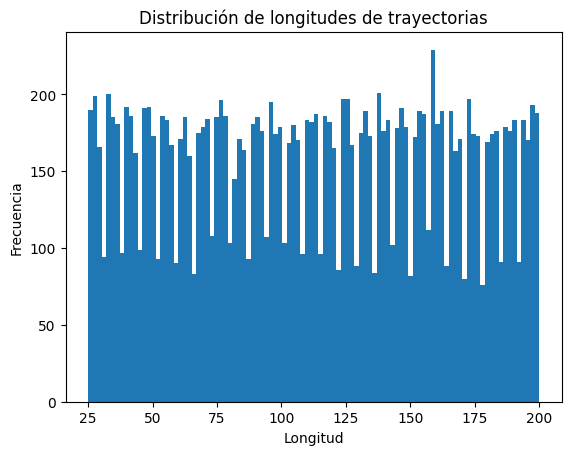

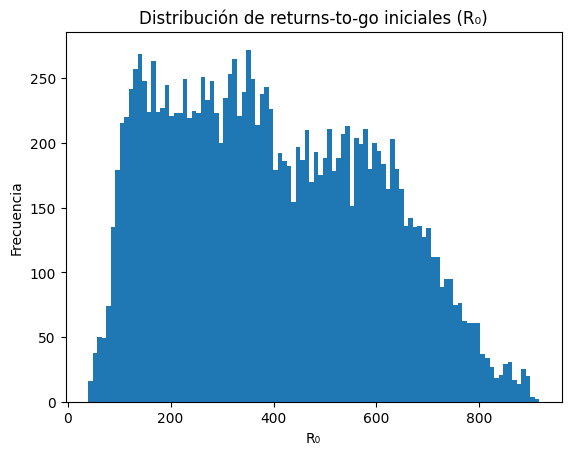

=== Cuartiles de R₀ (returns iniciales) ===
p25 = 229.0
p50 (mediana) = 378.0
p75 = 560.0
p95 = 738.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === 1. Distribución de longitudes ===
trajectory_lengths = [len(traj["items"]) for traj in trajectories]

plt.hist(trajectory_lengths, bins=100)
plt.title("Distribución de longitudes de trayectorias")
plt.xlabel("Longitud")
plt.ylabel("Frecuencia")
plt.show()


# === 2. Distribución de returns-to-go iniciales ===
initial_returns = [traj["returns_to_go"][0] for traj in trajectories]

plt.hist(initial_returns, bins=100)
plt.title("Distribución de returns-to-go iniciales (R₀)")
plt.xlabel("R₀")
plt.ylabel("Frecuencia")
plt.show()


# === 3. Cuartiles de returns ===
q25 = np.percentile(initial_returns, 25)
q50 = np.percentile(initial_returns, 50)
q75 = np.percentile(initial_returns, 75)
q95 = np.percentile(initial_returns, 95)

print("=== Cuartiles de R₀ (returns iniciales) ===")
print(f"p25 = {q25}")
print(f"p50 (mediana) = {q50}")
print(f"p75 = {q75}")
print(f"p95 = {q95}")


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#import pickle
#save_path = "/content/drive/MyDrive/Colab Notebooks/Diplomatura/Aprendizaje_por_Refuerzos/Practico2/datos_procesados/trajectories_train.pkl"
#with open(save_path, "wb") as f:
#    pickle.dump(trajectories, f)



# Parte 2

## Arquitectura de Desicion Transformer

In [ ]:
import torch
import torch.nn as nn


class DecisionTransformer(nn.Module):
    def __init__(
        self,
        num_items=471,      # Cantidad total de ítems (libros)
        num_groups=8,       # Cantidad de grupos (clusters) de usuarios
        hidden_dim=128,     # Dimensión del espacio latente en el Transformer
        n_layers=3,         # Capas del Transformer Encoder
        n_heads=4,          # Número de cabezas de atención
        context_length=20,  # Longitud máxima de la secuencia de entrada
        max_timestep=200,   # Máximo índice permitido para timesteps
        dropout=0.1         # Dropout interno del Transformer
    ):
        super().__init__()

        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.context_length = context_length



        # ============================================================
        #                    EMBEDDINGS DEL MODELO
        # ============================================================

        # Embedding de ítems (libros)
        # Convierte IDs de libros en vectores densos de dimensión hidden_dim
        self.item_embedding = nn.Embedding(num_items, hidden_dim)

        # Embedding del grupo de usuario (cluster)
        # Una sola etiqueta por usuario → embedding que luego replicamos en toda la secuencia
        self.group_embedding = nn.Embedding(num_groups, hidden_dim)

        # Embedding de return-to-go
        # RTG es un escalar → se convierte en un vector de hidden_dim vía capa Linear
        self.rtg_embedding = nn.Linear(1, hidden_dim)

        # Embedding de timestep (posicional)
        # Cada posición temporal t recibe un embedding aprendido
        self.timestep_embedding = nn.Embedding(max_timestep, hidden_dim)


        # ============================================================
        #                        TRANSFORMER
        # ============================================================

        # Capa básica del encoder transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,         # Dimensión del embedding
            nhead=n_heads,              # Número de cabezas de atención
            dim_feedforward=hidden_dim * 4,  # Tamaño del MLP interno
            dropout=dropout,            # Dropout
            activation='gelu',          # Activación recomendada para transformers modernos
            batch_first=True            # Input con forma (batch, seq_len, hidden)
        )

        # Conjunto de capas de encoder empiladas
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers
        )


        # ============================================================
        #                     CABEZA DE PREDICCIÓN
        # ============================================================

        # Convierte la salida del transformer en logits sobre ítems.
        # Predice qué item recomendar
        self.predict_item = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_items)  # Logits para cada ítem
        )

        # LayerNorm para estabilizar entrenamiento
        self.ln = nn.LayerNorm(hidden_dim)

    # ============================================================
    #                           FORWARD
    # ============================================================

    def forward(
        self,
        states,        # (batch, seq_len) items vistos en el pasado
        actions,       # (batch, seq_len) items recomendados (targets)
        returns_to_go, # (batch, seq_len, 1) valores R̂ para cada paso
        timesteps,     # (batch, seq_len) posiciones temporales
        user_groups,   # (batch,) cluster de cada usuario
        attention_mask=None  # Máscara causal opcional
    ):

        batch_size, seq_len = states.shape

        # --------------------------- Embeddings ---------------------------

        # Embedding de los estados (items ya vistos)
        state_emb = self.item_embedding(states)  # (B, L, H)

        # Embedding de acciones recomendadas
        action_emb = self.item_embedding(actions)  # (B, L, H)
        # (En esta versión no se usa explícitamente action_emb, pero queda para extensiones)

        # Embedding de returns-to-go
        rtg_emb = self.rtg_embedding(returns_to_go)  # (B, L, H)

        # Embedding de timestep posicional
        time_emb = self.timestep_embedding(timesteps)  # (B, L, H)

        # Embedding del grupo de usuario, replicado para cada timestep
        group_emb = self.group_embedding(user_groups).unsqueeze(1)  # (B,1,H)
        group_emb = group_emb.expand(-1, seq_len, -1)               # (B,L,H)



        # --------------------------- Combinación --------------------------

        # Sumamos todas las fuentes de información
        # Esta es una variante simplificada del Decision Transformer original
        # Formato: [rtg_0, state_0, action_0, rtg_1, state_1, action_1, ...]

        # Para simplicidad, usamos sum de embeddings + positional
        h = state_emb + rtg_emb + time_emb + group_emb

        # Normalización antes del Transformer
        h = self.ln(h)

        # --------------------------- Máscara causal -----------------------

        # Si no se da una máscara, generar una triangular superior
        #Asegurar que cada timestep solo ve el pasado
        if attention_mask is None:
            attention_mask = self._generate_causal_mask(seq_len).to(h.device)
            # Esta máscara impide que un timestep vea información del futuro


        # ------------------------------ Transformer -----------------------

        # Pasa por el encoder transformer (autoregresivo)
        h = self.transformer(h, mask=attention_mask)  # (B, L, H)

        # ----------------------------- Predicción -------------------------

        # Predice el ítem para cada timestep
        item_logits = self.predict_item(h)  # (B, L, num_items)

        return item_logits


    # ============================================================
    #                     Máscara causal (autoregresiva)
    # ============================================================

    def _generate_causal_mask(self, seq_len):
        """
        Crea máscara triangular superior con -inf para bloquear atención al futuro.
        """
        mask = torch.triu(
            torch.ones(seq_len, seq_len) * float('-inf'),
            diagonal=1
        )
        return mask



## Training Loop

In [ ]:
import torch.nn.functional as F
def train_decision_transformer(
    model,
    train_loader,
    optimizer,
    device,
    num_epochs=50
):
    """
    Entrena el Decision Transformer.

    La loss es cross-entropy entre:
        - logits predichos por el modelo
        - item verdadero (target) que se consumió en el siguiente paso

    El loop es estándar:
        1. Forwards
        2. Calcular pérdida
        3. Backprop + optimizer step
    """

    # Poner el modelo en modo entrenamiento
    # - activa dropout
    # - activa layernorm en modo training
    model.train()
  # === NUEVO: diccionario para plot de pérdidas ===
    history = {
        'train_loss': []
    }

    # Loop de epochs
    for epoch in range(num_epochs):
        total_loss = 0   # acumulador para imprimir loss promedio

        # Iterar sobre los batches del dataloader
        for batch in train_loader:

            # ===========================
            #    1. MOVER A DISPOSITIVO
            # ===========================
            # (B, L)
            states = batch['states'].to(device)
            actions = batch['actions'].to(device)

            # (B, L, 1)
            rtg = batch['rtg'].to(device)

            # (B, L)
            timesteps = batch['timesteps'].to(device)

            # (B,)
            groups = batch['groups'].to(device)

            # (B, L) ítems a predecir (shifted)
            targets = batch['targets'].to(device)

            # ===========================
            #        2. FORWARD
            # ===========================
            # El modelo devuelve logits de dimensión:
            # (B, L, num_items)
            logits = model(states, actions, rtg, timesteps, groups)


            # ===========================
            #        3. PÉRDIDA
            # ===========================
            # La cross entropy espera tensores:
            # logits: (N, num_classes)
            # targets: (N)
            #
            # Se aplana (B*L, num_items) y (B*L)

            loss = F.cross_entropy(
                logits.reshape(-1, model.num_items),
                targets.reshape(-1),
                ignore_index=-1  # ignora posiciones con padding
            )
            # ===========================
            #      4. BACKPROP
            # ===========================
            optimizer.zero_grad()     # reset gradientes previos
            loss.backward()           # backprop estándar

            # Clip evita explosiones en el gradiente en Transformers
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()          # actualiza los pesos

            total_loss += loss.item()

        # ===========================
        #    5. IMPRIMIR MÉTRICAS
        # ===========================
        # Promedio por epoch
        avg_loss = total_loss / len(train_loader)

        # === guardar en history ===
        history['train_loss'].append(avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return model, history


## DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class RecommendationDataset(Dataset):
    def __init__(self, trajectories, context_length=20):
        # Lista de trayectorias en formato Decision Transformer:
        self.trajectories = trajectories

        # Longitud máxima de ventana (contexto que verá el transformer)
        self.context_length = context_length


    def __len__(self):
        # Cantidad de trayectorias (un usuario = una trayectoria)
        return len(self.trajectories)

    def __getitem__(self, idx):
        # ==== 1. Seleccionar trayectoria ====
        traj = self.trajectories[idx]

        # Extraer secuencias completas
        items = traj['items']              # np.array de item IDs
        ratings = traj['ratings']          # no usado directamente
        rtg = traj['returns_to_go']        # np.array con returns-to-go
        timesteps = traj['timesteps']      # 0,1,2,...,T-1
        group = traj['user_group']         # entero 0–7


        # ==== 2. Determinar ventana temporal (context) ====
        # El Transformer puede ver como máximo "context_length" pasos
        seq_len = min(len(items), self.context_length)

        # Si la secuencia es más larga que el contexto, cortamos una ventana aleatoria
        # Esto funciona como data augmentation
        if len(items) > self.context_length:
            # Elegir índice inicial aleatorio
            start_idx = np.random.randint(0, len(items) - self.context_length + 1)
        else:
            start_idx = 0

        end_idx = start_idx + seq_len


        # ==== 3. Construir inputs del modelo ====

        # STATES:
        # En Decision Transformer, "states" = historial de items vistos
        # Para entrenamiento autoregresivo usamos exactamente la secuencia recortada
        states = items[start_idx:end_idx]

        # ACTIONS:
        # En RL real serían acciones explícitas, aquí se igualan a los states
        # Actions: items que fueron "recomendados" (mismo que states shifted)
        actions = items[start_idx:end_idx]

        # ==== 4. Construir targets ====
        # "targets" son los items que queremos que el modelo prediga
        # Un shift: target[t] = item real en t+1
        targets = np.zeros(seq_len, dtype=np.int64)

        # Todos menos el último se completan con el ítem siguiente
        targets[:-1] = items[start_idx+1:end_idx]

        # El último no tiene un siguiente → padding con -1 (ignored index)
        targets[-1] = -1


        # ==== 5. Recortar returns-to-go ====
        # rtg[t] = suma de rewards desde t hasta fin
        # reshape para que el modelo reciba (B, L, 1)
        rtg_seq = rtg[start_idx:end_idx].reshape(-1, 1)

        # ==== 6. Recortar timesteps ====
        time_seq = timesteps[start_idx:end_idx]

        # ==== 7. Convertir a tensores PyTorch ====
        return {
            'states': torch.tensor(states, dtype=torch.long),          # (L,)
            'actions': torch.tensor(actions, dtype=torch.long),        # (L,)
            'rtg': torch.tensor(rtg_seq, dtype=torch.float32),         # (L, 1)
            'timesteps': torch.tensor(time_seq, dtype=torch.long),     # (L,)
            'groups': torch.tensor(group, dtype=torch.long),           # entero
            'targets': torch.tensor(targets, dtype=torch.long)         # (L,)
        }


## Entrenamiento

### Creamos Dataset y DataLoader

In [ ]:
dataset = RecommendationDataset(trajectories, context_length=20)

train_loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
)


### Instanciamos el modelo Decision Transformer

In [ ]:
import torch

# Detectar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)


Using device: cpu


In [ ]:
NUM_ITEMS = 472  # o 752 si usás Netflix

model = DecisionTransformer(
    num_items=NUM_ITEMS,  #  obligatorio
    num_groups=8,
    hidden_dim=128,
    n_layers=3,
    n_heads=4,
    context_length=20
).to(device)



### Crear Optimizador

In [ ]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=1e-4)


Chequeos

In [ ]:
#Comprobar formas (shapes) del batch
batch = next(iter(train_loader))

for k,v in batch.items():
    print(k, v.shape)


states torch.Size([32, 20])
actions torch.Size([32, 20])
rtg torch.Size([32, 20, 1])
timesteps torch.Size([32, 20])
groups torch.Size([32])
targets torch.Size([32, 20])


In [ ]:
#Verificar que num_items coincida con los IDs máximos de items
max_item = max(max(t['items']) for t in trajectories)
print("Máximo item ID:", max_item)


Máximo item ID: 471


In [ ]:
#Verificar que los targets tienen valores válidos
import numpy as np
all_targets = np.concatenate([t['items'][1:] for t in trajectories])
print(all_targets.min(), all_targets.max())


0 471


### Entrenar el modelo

In [ ]:
decision_transformer_model, history = train_decision_transformer(
    model,
    train_loader,
    optimizer,
    device,
    num_epochs=15
)


Epoch 1/15, Loss: 6.1591
Epoch 2/15, Loss: 6.1581
Epoch 3/15, Loss: 6.1580
Epoch 4/15, Loss: 6.1578
Epoch 5/15, Loss: 6.1577
Epoch 6/15, Loss: 6.1576
Epoch 7/15, Loss: 6.1576
Epoch 8/15, Loss: 6.1574
Epoch 9/15, Loss: 6.1573
Epoch 10/15, Loss: 6.1573
Epoch 11/15, Loss: 6.1572
Epoch 12/15, Loss: 6.1572
Epoch 13/15, Loss: 6.1571
Epoch 14/15, Loss: 6.1571
Epoch 15/15, Loss: 6.1571


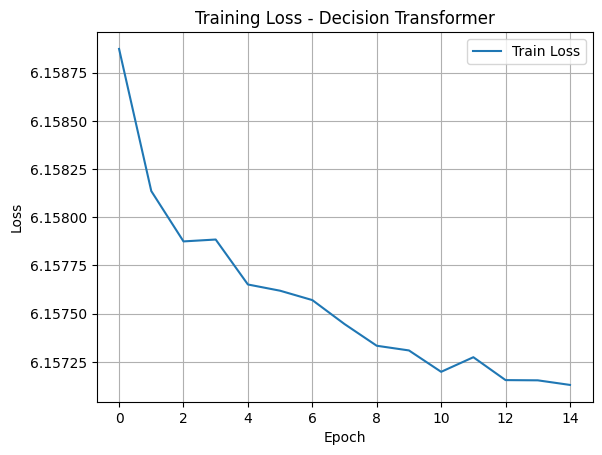

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss - Decision Transformer")
plt.grid(True)
plt.legend()
plt.show()


# Parte 3

## Baselines y Evaluación

### Baseline 1: Popularity

In [ ]:
class PopularityRecommender:
    def __init__(self):
        self.item_counts = None
        self.popular_items = None

    def fit(self, train_data):
        # Contar frecuencia de cada item
        all_items = np.concatenate([traj['items'] for traj in train_data])
        self.item_counts = np.bincount(all_items, minlength=752)
        self.popular_items = np.argsort(self.item_counts)[::-1]

    def recommend(self, user_history, k=10):
        # Recomendar los k items más populares que no estén en history
        recommendations = []
        for item in self.popular_items:
            if item not in user_history:
                recommendations.append(item)
            if len(recommendations) == k:
                break
        return recommendations

Entrenamiento

In [ ]:
import numpy as np

# Suponiendo que ya tienes `trajectories` y `NUM_ITEMS` definido
pop_model = PopularityRecommender()   # Crear instancia
pop_model.fit(trajectories)           # Ajustar al dataset

# Recomendar
user_0_history = trajectories[0]['items']
top10_recs = pop_model.recommend(user_0_history, k=10)
print(top10_recs)


[np.int64(149), np.int64(168), np.int64(84), np.int64(31), np.int64(115), np.int64(397), np.int64(54), np.int64(157), np.int64(2), np.int64(210)]


### Baseline 2: Behavior Cloning (Transformer sin R̂)



In [ ]:
import torch
import torch.nn as nn


# Similar a DecisionTransformer pero SIN rtg_embedding
# Solo usa: item_embedding + timestep_embedding
class BehaviorCloningTransformer(nn.Module):
    """
    Transformer que predice P(a_t | s_t, history)
    Sin conditioning en return-to-go.
    """
    def __init__(self, num_items, hidden_dim, n_layers, n_heads):
        super().__init__()
        # Similar a DecisionTransformer pero SIN rtg_embedding
        # Solo usa: item_embedding + timestep_embedding
        ...
class BehaviorCloningTransformer(nn.Module):
    """
    Transformer que predice P(a_t | s_t, history)
    Sin conditioning en return-to-go.
    """
    def __init__(self, num_items, hidden_dim=128, n_layers=3, n_heads=4, max_timestep=200, dropout=0.1):
        super().__init__()

        self.num_items = num_items
        self.hidden_dim = hidden_dim

        # ============================================================
        #                    EMBEDDINGS DEL MODELO
        # ============================================================

        # Embedding de ítems (historia)
        self.item_embedding = nn.Embedding(num_items, hidden_dim)

        # Embedding posicional de timestep
        self.timestep_embedding = nn.Embedding(max_timestep, hidden_dim)

        # ============================================================
        #                        TRANSFORMER
        # ============================================================

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers
        )


        # ============================================================
        #                     CABEZA DE PREDICCIÓN
        # ============================================================

        # Predecir próximo item
        self.predict_item = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_items)
        )

        # Layer normalization antes del transformer
        self.ln = nn.LayerNorm(hidden_dim)


    # ============================================================
    #                           FORWARD
    # ============================================================

    def forward(self, states, actions=None, returns_to_go=None, timesteps=None, user_groups=None, attention_mask=None):
      """ Args:
      states: (batch, seq_len) - IDs de items vistos
      actions: ignorado
      returns_to_go: ignorado
      timesteps: (batch, seq_len) - posiciones temporales
      user_groups: ignorado
      attention_mask: máscara causal opcional
      Returns: item_logits: (batch, seq_len, num_items) """

      batch_size, seq_len = states.shape


        # --------------------------- Embeddings ---------------------------

       # Embedding de items
      state_emb = self.item_embedding(states)  # (B, L, H)

       # Embedding posicional
      time_emb = self.timestep_embedding(timesteps)  # (B, L, H)

        # Sumamos embeddings
      h = state_emb + time_emb

        # Normalización antes del transformer
      h = self.ln(h)


      # --------------------------- Máscara causal -----------------------

      if attention_mask is None:
            attention_mask = self._generate_causal_mask(seq_len).to(h.device)

        # ------------------------------ Transformer -----------------------

      h = self.transformer(h, mask=attention_mask)  # (B, L, H)

        # ----------------------------- Predicción -------------------------

      item_logits = self.predict_item(h)  # (B, L, num_items)
      return item_logits

    # ============================================================
    #                     Máscara causal (autoregresiva)
    # ============================================================

    def _generate_causal_mask(self, seq_len):
        """
        Crea máscara triangular superior con -inf para bloquear atención al futuro.
        """
        mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1)
        return mask



Entrenamiento

In [ ]:
# Parámetros
NUM_ITEMS = 472   # o 752
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Crear modelo
bc_model = BehaviorCloningTransformer(
    num_items=NUM_ITEMS,
    hidden_dim=128,
    n_layers=3,
    n_heads=4
).to(device)

# Ejemplo de forward
batch = next(iter(train_loader))
states = batch['states'].to(device)
timesteps = batch['timesteps'].to(device)

logits = bc_model(
    states=states,
    timesteps=timesteps
)
print(logits.shape)  # (batch, seq_len, num_items)


torch.Size([32, 20, 472])


## Métricas de Evaluación

### Implementación

In [ ]:
import torch
import numpy as np

def hit_rate_at_k(predictions, targets, k=10):
    """
    Mide: ¿Está el item correcto dentro de las top-K recomendaciones?

    Interpretación:
    - HR@10 = 0.8 significa que en 80% de los casos, el item que el usuario
      realmente quería está dentro de las 10 mejores recomendaciones.
    - Valores más altos = mejor
    - Rango: [0, 1]

    Ejemplo:
    - Predicciones para un usuario: [item_42: 0.9, item_15: 0.7, item_3: 0.6, ...]
    - Target real: item_15
    - Top-3: [item_42, item_15, item_3]
    - ¿Está item_15 en top-3? → SÍ → Hit = 1

    Args:
        predictions: (batch, num_items) - scores/probabilidades para cada item
        targets: (batch,) - item verdadero que debería recomendarse
        k: número de top items a considerar (ej: 5, 10, 20)

    Returns:
        hit_rate: float entre 0 y 1 (proporción de hits en el batch)
    """
    # Obtener índices de los top-K items para cada ejemplo
    # Ej: k=10 → obtiene los 10 items con mayor probabilidad

    top_k = torch.topk(predictions, k, dim=1).indices  # (batch, k)

    # Comparar si target está dentro de top-k → True/False
    # Verificar si el target está en alguna de las k posiciones
    # unsqueeze(1) convierte targets de (batch,) a (batch, 1) para broadcasting
    hits = (top_k == targets.unsqueeze(1)).any(dim=1).float()  # (batch,)

    # Promedio sobre todo el batch
    return hits.mean().item()



def ndcg_at_k(predictions, targets, k=10):
    """
    Normalized Discounted Cumulative Gain @K (NDCG@K).

    Mide: ¿Qué tan alto está rankeado el item correcto?

    Interpretación:
    - NDCG@10 = 1.0 → el item correcto está en posición #1 (perfecto!)
    - NDCG@10 = 0.63 → el item correcto está en posición #2
    - NDCG@10 = 0.5 → el item correcto está en posición #3
    - Valores más altos = mejor
    - Penaliza más si el item correcto está en posiciones bajas

    Diferencia con HR@K:
    - HR@K: solo importa SI está en top-k (binario: sí/no)
    - NDCG@K: importa DÓNDE está en top-k (posición exacta)

    Ejemplo:
    - Target en posición 1 → NDCG = 1.0 / log2(2) = 1.0 / 1 = 1.0
    - Target en posición 2 → NDCG = 1.0 / log2(3) = 1.0 / 1.585 ≈ 0.63
    - Target en posición 5 → NDCG = 1.0 / log2(6) = 1.0 / 2.585 ≈ 0.39

    Nota: log2 = logaritmo en base 2 (log2(2)=1, log2(4)=2, log2(8)=3)

    Args:
        predictions: (batch, num_items) - scores para cada item
        targets: (batch,) - item verdadero
        k: top-K items a considerar

    Returns:
        ndcg: float entre 0 y 1 (promedio en el batch)
    """
    # Top-K indices predichos
    top_k_indices = torch.topk(predictions, k, dim=1).indices  # (batch, k)

    # Relevancia = 1 si el target está en top-k, 0 si no
    # Crear vector de relevancia (1 si es el target, 0 si no)
    # Esto marca en qué posición (si alguna) está el target
    relevance = (top_k_indices == targets.unsqueeze(1)).float()  # (batch, k)

    # Posiciones 1..K
    # Calcular DCG (Discounted Cumulative Gain)
    # DCG penaliza items relevantes en posiciones bajas con log2(rank+1)
    # ranks = [1, 2, 3, ..., k]
    ranks = torch.arange(1, k+1, device=predictions.device).float()  # (k,)

    # DCG = Σ (relevancia_i / log2(posición_i + 1))
    # Nota: log2 = logaritmo en base 2 (ej: log2(2)=1, log2(4)=2, log2(8)=3)
    # El +1 en el denominador hace que:
    #   - posición 1 → log2(2) = 1.0
    #   - posición 2 → log2(3) ≈ 1.585
    #   - posición 3 → log2(4) = 2.0
    dcg = (relevance / torch.log2(ranks + 1)).sum(dim=1)  # (batch,)

    # Calcular IDCG (Ideal DCG)
    # Es el DCG máximo posible = cuando el target está en posición 1
    # IDCG = 1.0 / log2(1+1) = 1.0 / log2(2) = 1.0 / 1.0 = 1.0
    # (porque log2(2) = 1, ya que 2^1 = 2)
    idcg = 1.0 / np.log2(2)

    # Normalizar: NDCG = DCG / IDCG
    # Esto hace que NDCG esté siempre entre 0 y 1
    ndcg = dcg / idcg  # Normalizamos a [0,1]
    return ndcg.mean().item()



def mrr(predictions, targets):
    """
    Mean Reciprocal Rank (MRR).

    Mide: ¿En qué posición está el item correcto en el ranking completo?

    Interpretación:
    - MRR = 1.0 → target en posición #1 (perfecto!)
    - MRR = 0.5 → target en posición #2
    - MRR = 0.33 → target en posición #3
    - MRR = 0.1 → target en posición #10
    - Valores más altos = mejor
    - Fórmula: MRR = 1 / rank_del_target

    Diferencia con NDCG:
    - NDCG: usa log para penalizar (más suave)
    - MRR: usa 1/rank directamente (penalización más fuerte)

    Ejemplo:
    - 752 películas rankeadas por el modelo
    - Target está en posición 5
    - RR (Reciprocal Rank) = 1/5 = 0.2
    - MRR = promedio de RR en todo el dataset

    Args:
        predictions: (batch, num_items) - scores para cada item
        targets: (batch,) - item verdadero

    Returns:
        mrr: float entre 0 y 1 (promedio de reciprocal ranks)
    """
    # Ordenar todos los items por score de mayor a menor score
    sorted_indices = torch.argsort(predictions, dim=1, descending=True)  # (batch, num_items)

    # Encontrar el rank del target en cada ejemplo
    # Encontrar en qué posición está el target para cada ejemplo
    # nonzero() encuentra dónde está True
    # [:,1] obtiene la columna (posición en el ranking)
    # +1 porque las posiciones empiezan en 0 pero queremos ranks desde 1
    ranks = (sorted_indices == targets.unsqueeze(1)).nonzero()[:, 1] + 1  # +1 porque rank empieza en 1

    # Reciprocal Rank = 1 / posición
    # Ej: si target está en posición 3 → RR = 1/3 = 0.333
    rr = 1.0 / ranks.float()

    # Promedio en el batch
    return rr.mean().item()


### Evaluación en loop

In [ ]:
@torch.no_grad()  # Desactiva gradientes → más rápido y menos memoria
def evaluate_model(model, test_data, device, target_return=None, k_list=[5, 10, 20]):
    """
    Evalúa un modelo de recomendación en un test set (usuarios cold-start).

    Args:
        model: modelo entrenado (Decision Transformer o Behavior Cloning Transformer)
        test_data: lista de usuarios de test, cada uno con:
            - 'group': ID del grupo
            - 'items': lista de IDs de items consumidos
            - 'ratings': lista de ratings (para RTG si aplica)
        target_return: valor de R̂ a usar como conditioning (solo DT). Si None, usa suma histórica
        k_list: lista de K para métricas @K (HR@K, NDCG@K)

    Returns:
        metrics: diccionario con métricas promediadas sobre todo el test set
    """
    model.eval()  # Modo evaluación → desactiva dropout, layernorm fija

    # Diccionario para acumular métricas
    metrics = {f'HR@{k}': [] for k in k_list}
    metrics.update({f'NDCG@{k}': [] for k in k_list})
    metrics['MRR'] = []


    # Iterar sobre cada usuario del test set
    for user in test_data:
        group = user['group']
        items = user['items']
        ratings = user['ratings']

        # Definir longitud de historia a considerar como contexto
        context_len = 20


        # Iterar sobre cada paso temporal para simular sesión
        for t in range(context_len, len(items)):
            # Historia hasta el paso t
            history_items = items[t-context_len:t]
            history_ratings = ratings[t-context_len:t]

            # Calcular return-to-go si aplica (solo DT)
            if target_return is None:
                rtg = sum(history_ratings)  # suma de ratings históricos
            else:
                rtg = target_return


            # Preparar tensores de entrada
            states = torch.tensor(history_items, dtype=torch.long).unsqueeze(0).to(device)
            actions = torch.tensor(history_items, dtype=torch.long).unsqueeze(0).to(device)
            rtg_input = torch.full((1, context_len, 1), rtg, dtype=torch.float32).to(device)
            timesteps = torch.arange(context_len, dtype=torch.long).unsqueeze(0).to(device)
            groups = torch.tensor([group], dtype=torch.long).to(device)


            # Predecir siguiente item
            # El modelo devuelve logits de forma (batch, seq_len, num_items)
            # batch=1, seq_len=t+1 (historia hasta ahora), num_items=752 (o 472)
            # Forward pass del modelo
            # Output: (batch=1, seq_len=context_len, num_items)
            logits = model(states, actions, rtg_input, timesteps, groups)


            # Extraer predicción para el siguiente item
            # logits[0, -1, :] toma:
            #   - [0]: primer (y único) ejemplo del batch
            #   - [-1]: última posición temporal (la más reciente)
            #   - [:]: scores (logits) para todos los items posibles
            #
            # IMPORTANTE: Son LOGITS (scores sin normalizar), NO probabilidades
            # - Logits pueden ser cualquier valor real: -5, 0, 3.2, 100, etc.
            # - Para las métricas (HR@K, NDCG@K, MRR) solo importa el RANKING
            # - NO necesitamos aplicar softmax porque el orden no cambia
            #
            # Resultado: vector (num_items,) con score para cada item
            predictions = logits[0, -1, :]

            # Target
            target_item = items[t]


            # Calcular métricas @K
            for k in k_list:
                hr = hit_rate_at_k(predictions.unsqueeze(0),
                                   torch.tensor([target_item]).to(device), k)
                metrics[f'HR@{k}'].append(hr)

                ndcg = ndcg_at_k(predictions.unsqueeze(0),
                                torch.tensor([target_item]).to(device), k)
                metrics[f'NDCG@{k}'].append(ndcg)

            # Calcular MRR
            mrr_val = mrr(predictions.unsqueeze(0),
                         torch.tensor([target_item]).to(device))
            metrics['MRR'].append(mrr_val)

    # Promediar métricas sobre todos los usuarios/pasos
    return {key: np.mean(val) for key, val in metrics.items()}


Como usarlo

In [ ]:
#Para Decision Transformer
metrics_dt = evaluate_model(
    model=decision_transformer_model,  # tu modelo entrenado
    test_data=test_users,       # lista de diccionarios {'group', 'items', 'ratings'}
    device=device                       # 'cuda' o 'cpu'
)

print(metrics_dt)


{'HR@5': np.float64(0.011061946902654867), 'HR@10': np.float64(0.022123893805309734), 'HR@20': np.float64(0.04424778761061947), 'NDCG@5': np.float64(0.006523139774799347), 'NDCG@10': np.float64(0.010052122637233903), 'NDCG@20': np.float64(0.01557581515702526), 'MRR': np.float64(0.01447838859939618)}


In [ ]:
#Para Behavior Cloning Transformer (Baseline 2)
metrics_bc = evaluate_model(
    model=bc_model,
    test_data=test_users,
    device=device
)


In [ ]:
print(metrics_bc)

{'HR@5': np.float64(0.004424778761061947), 'HR@10': np.float64(0.017699115044247787), 'HR@20': np.float64(0.0420353982300885), 'NDCG@5': np.float64(0.0019620637846204034), 'NDCG@10': np.float64(0.006164843595660894), 'NDCG@20': np.float64(0.012025014653933786), 'MRR': np.float64(0.010995621416940295)}


Popularity Recommender no usa Transformer ni tensores. Hay que adaptar la función:

In [ ]:
def evaluate_popularity_model(model, test_data, k_list=[5, 10, 20]):
    """
    Evalúa el PopularityRecommender sobre un test set usando:
    - Hit Rate @K
    - NDCG @K
    - MRR

    NOTA: Popularity no produce logits, así que simulamos scores
          simplemente para poder usar las métricas existentes.
    """
    metrics = {f'HR@{k}': [] for k in k_list}
    metrics.update({f'NDCG@{k}': [] for k in k_list})
    metrics['MRR'] = []

    for user in test_data:
        items = user['items']
        context_len = 20  # igual que Decision Transformer

        for t in range(context_len, len(items)):
            history = items[t-context_len:t]
            target_item = items[t]

            # Obtener recomendaciones (más populares no vistos)
            # Pedimos el máximo K necesario
            max_k = max(k_list)
            recommended_items = model.recommend(history, k=max_k)

            # Convertimos recomendaciones a tensores para métricas
            recommended_items = torch.tensor(recommended_items).unsqueeze(0)  # shape (1, max_k)

            # Simulamos "scores" decrecientes: item más popular → score mayor
            scores = torch.arange(max_k, 0, -1).float().unsqueeze(0)

            # Calcular métricas @K
            for k in k_list:
                # Recortamos a top-k
                pred_scores = scores[:, :k]
                pred_items = recommended_items[:, :k]

                hr = hit_rate_at_k(pred_items, torch.tensor([target_item]), k=k)
                metrics[f'HR@{k}'].append(hr)

                ndcg_val = ndcg_at_k(pred_items, torch.tensor([target_item]), k=k)
                metrics[f'NDCG@{k}'].append(ndcg_val)

            # MRR (ranking completo de max_k items)
            mrr_val = mrr(scores, torch.tensor([target_item]))
            metrics['MRR'].append(mrr_val)

    return {key: np.mean(val) for key, val in metrics.items()}


In [ ]:
#Cálculo de métricas


metrics_pop = evaluate_popularity_model(pop_model, test_users)
print(metrics_pop)


{'HR@5': np.float64(0.0), 'HR@10': np.float64(0.0), 'HR@20': np.float64(0.0), 'NDCG@5': np.float64(0.0), 'NDCG@10': np.float64(0.0), 'NDCG@20': np.float64(0.0), 'MRR': np.float64(nan)}


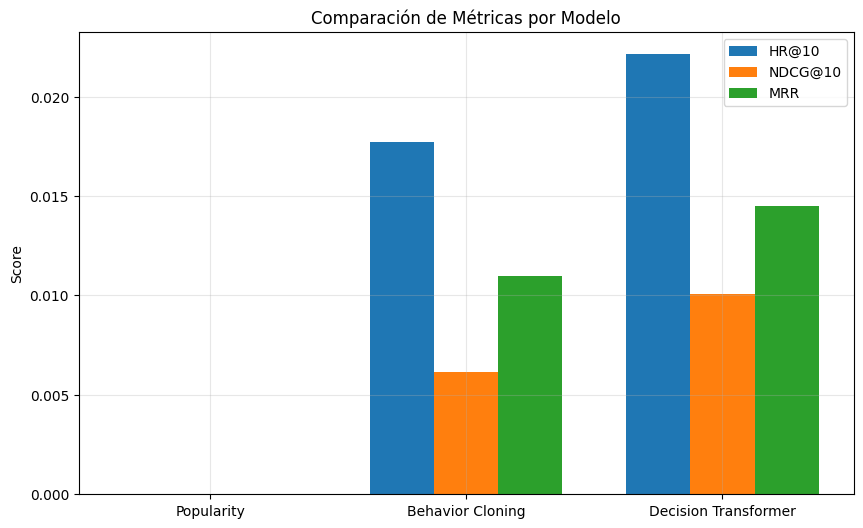

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Definir los modelos y métricas
models = ['Popularity', 'Behavior Cloning', 'Decision Transformer']
hr10 = [metrics_pop['HR@10'], metrics_bc['HR@10'], metrics_dt['HR@10']]
ndcg10 = [metrics_pop['NDCG@10'], metrics_bc['NDCG@10'], metrics_dt['NDCG@10']]
mrr2 = [metrics_pop['MRR'], metrics_bc['MRR'], metrics_dt['MRR']]

x = np.arange(len(models))  # posiciones en x
width = 0.25  # ancho de las barras

# 2️⃣ Crear gráfico de barras
plt.figure(figsize=(10,6))
plt.bar(x - width, hr10, width, label='HR@10')
plt.bar(x, ndcg10, width, label='NDCG@10')
plt.bar(x + width, mrr2, width, label='MRR')

plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Comparación de Métricas por Modelo')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Parte 4

 **Experimentos con Return Conditioning**
## Efecto de Target Return

p25 (R̂=229.0000): HR@10=0.019912, NDCG@10=0.009386
p50 (R̂=378.0000): HR@10=0.019912, NDCG@10=0.009386
p75 (R̂=560.0000): HR@10=0.019912, NDCG@10=0.009386
p90 (R̂=678.0000): HR@10=0.019912, NDCG@10=0.009386


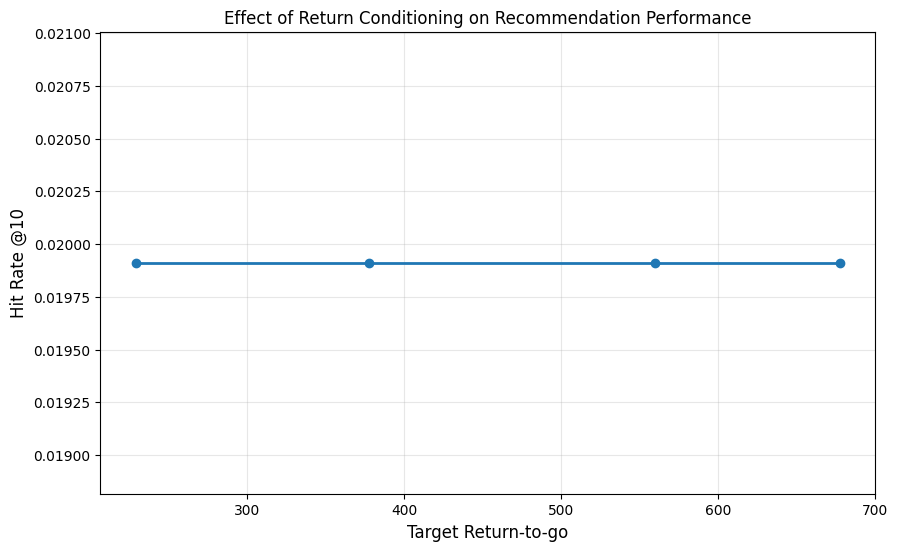

In [ ]:
# Calcular estadísticas de returns en training
train_returns = [traj['returns_to_go'][0] for traj in trajectories]
percentiles = {
    'p25': np.percentile(train_returns, 25),
    'p50': np.percentile(train_returns, 50),
    'p75': np.percentile(train_returns, 75),
    'p90': np.percentile(train_returns, 90),
    #'max': np.max(train_returns)
}

# Evaluar con cada return objetivo
results = {}
for name, rtg_value in percentiles.items():
    metrics = evaluate_model(decision_transformer_model, test_users, device, target_return=rtg_value)
    results[name] = metrics
    print(f'{name} (R̂={rtg_value:.4f}): HR@10={metrics["HR@10"]:.6f}, NDCG@10={metrics["NDCG@10"]:.6f}')

# Graficar: Return objetivo vs Performance
import matplotlib.pyplot as plt

rtg_values = list(percentiles.values())
hr10_values = [results[name]['HR@10'] for name in percentiles.keys()]

plt.figure(figsize=(10, 6))
plt.plot(rtg_values, hr10_values, marker='o', linewidth=2)
plt.xlabel('Target Return-to-go', fontsize=12)
plt.ylabel('Hit Rate @10', fontsize=12)
plt.title('Effect of Return Conditioning on Recommendation Performance')
plt.grid(True, alpha=0.3)
plt.show()

## Cold-Start Performance

In [ ]:
# Agrupar test users por grupo
results_by_group = {}
for group_id in range(8):
    users_in_group = [u for u in test_users if u['group'] == group_id]

    if users_in_group:
        metrics = evaluate_model(decision_transformer_model, users_in_group, device, target_return=percentiles['p75'])
        results_by_group[group_id] = metrics
        print(f'Group {group_id}: HR@10={metrics["HR@10"]:.4f}')

# Comparar con baseline que usa centroides de grupos
# Este baseline NO usa el transformer, solo recomienda items
# con ratings altos en el centroide del grupo (mu_netflix8.csv)









Group 0: HR@10=0.0199
Group 1: HR@10=0.0199
Group 2: HR@10=0.0199
Group 3: HR@10=0.0199
Group 4: HR@10=0.0199
Group 5: HR@10=0.0199
Group 6: HR@10=0.0199
Group 7: HR@10=0.0199
